In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Подготовка данных

In [2]:
df_images = pd.read_csv("offsets_coordinates.csv")
df_1 = pd.read_excel("1.xlsx")
df_2 = pd.read_excel("2.xlsx")

In [3]:
df_answers = pd.concat([df_1, df_2], axis=1)
df_answers.head()

,time,gender,is_with_video,normal,hor_left_3,hor_left_5,hor_left_8,hor_left_11,hor_right_4,hor_right_7,...,hor_left_12,hor_left_14,hor_right_6,hor_right_9,hor_right_13,seq_large_6,seq_large_11,seq_small_5,seq_small_6,seq_small_9
0,2023-10-25 20:01:54.491,Ж,Нет,4,2,2,3,2,4,4,...,3,2,4,4,2,4,4,5,2,2
1,2023-10-25 20:42:42.954,М,Да,5,5,4,3,3,4,3,...,2,3,4,3,4,5,5,4,3,2
2,2023-10-25 20:49:30.885,Ж,Да,2,4,4,2,3,4,2,...,2,2,2,1,2,3,4,4,3,1
3,2023-10-25 20:56:49.366,Ж,Да,4,4,3,2,2,3,2,...,2,2,3,2,2,4,2,5,3,2
4,2023-10-25 21:11:51.331,Ж,Да,5,5,4,4,4,4,3,...,2,2,3,3,2,4,4,5,2,2


In [4]:
# считаем количество оценок в каждом столбце df_answers
ratings = ['5', '4', '3', '2', '1']

df_count_ratings = pd.DataFrame()
for column in df_answers.columns.difference(['time', 'gender', 'is_with_video', 'age']):
    df_count_ratings[column] = [df_answers[column].eq(int(rating)).sum() for rating in ratings]

df_count_ratings.index = ratings[0:5]  
df_count_ratings = df_count_ratings.transpose()
df_count_ratings.head()

,5,4,3,2,1
hor_left_11,1,10,15,16,1
hor_left_12,1,9,18,13,2
hor_left_14,0,3,19,17,4
hor_left_3,16,19,6,2,0
hor_left_4,11,24,7,1,0


In [5]:
# считаем среднее значение оценки для кажого столбца
numeric_columns = df_answers.select_dtypes(include='number')
column_mean_map = numeric_columns.mean().to_dict()
df_images['mean'] = df_images['name'].map(column_mean_map)

# Объединяем датафреймы по столбцу 'name'
df_result = pd.merge(df_images, df_count_ratings, left_on='name', right_index=True)
df_result.head()

,name,1_x,1_y,9_x,9_y,17_x,17_y,28_x,28_y,up_y,square,mean,5,4,3,2,1
0,normal,678,321,828,584,836,304,996,314,197,138384,4.418605,23,16,3,1,0
1,hor_left_3,600,324,755,584,760,303,922,313,197,138012,4.139535,16,19,6,2,0
2,hor_left_4,576,318,729,584,735,303,895,312,197,138384,4.046512,11,24,7,1,0
3,hor_left_5,550,323,703,583,710,304,868,314,197,138384,3.860465,9,22,9,3,0
4,hor_left_7,502,323,655,584,661,305,819,316,197,138384,3.627907,4,24,11,3,1


# Оценка 5

In [6]:
# ГОРИЗОНТАЛЬНОЕ СМЕЩЕНИЕ
df_hor = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('hor_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "5" поставили пользователи
num = df_hor.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_hor.iloc[i]]*(df_hor['5'][i] - 1))
    df_hor = pd.concat([df_hor, tmp], ignore_index=True)


# ВЕРТИКАЛЬНОЕ СМЕЩЕНИЕ
df_ver = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('ver_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "5" поставили пользователи
num = df_ver.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_ver.iloc[i]]*(df_ver['5'][i] - 1))
    df_ver = pd.concat([df_ver, tmp], ignore_index=True)


# КРУПНОСТЬ ЛИЦА
df_seq = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('seq_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "5" поставили пользователи
num = df_seq.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_seq.iloc[i]]*(df_seq['5'][i] - 1))
    df_seq = pd.concat([df_seq, tmp], ignore_index=True)   

## Вычисление параметров смещения

У нас есть график распределения оценок в зависимости от расстояния. Вопрос, на который теперь мы можем ответить: "В каком интервале с вероятностью 0.95 пользователь из генеральной совокупности поставит оценку 5 изображению?"  
Чтобы ответить на этот вопрос, можно использовать t-test для проверки средних значений выборок. Но его применение ограничивается следующими условиями:  
1. В выборке достаточно большое количество измерений  
2. Распределение выборки схоже с нормальным  

Проведем все необходимые измерения на примере горизонтального смещения изображения.

### Вычисления для горизонтальногго смещения

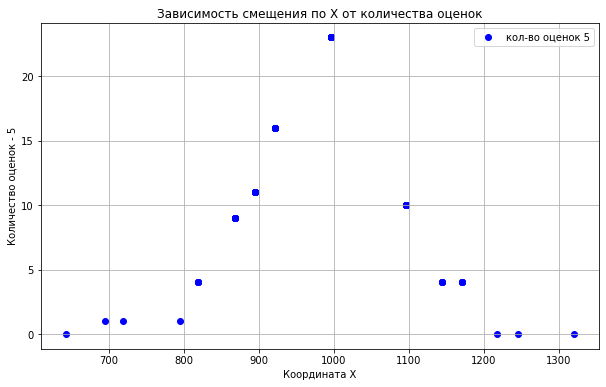

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(df_hor['28_x'], df_hor['5'], color='blue', label='кол-во оценок 5')
plt.title('Зависимость смещения по X от количества оценок')
plt.xlabel('Координата X')
plt.ylabel('Количество оценок - 5')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
df_hor.shape

(88, 17)

Распределение визуально похоже на нормальное, и количество измерений - 88, то есть больше 30. Но все равно проведем статистический тест Шапиро-Уилка для определения схожести с нормальным распределением.  
Выдвенем гипотезы:  
$H_1$: Данные распреелены нормально  
$H_2$: Данные распределены не нормально  
Возьмем стандартный уровень значимости 
$\alpha$ = 0.05

In [9]:
stat, p_value = shapiro(df_hor['28_x'])

alpha = 0.05
if p_value < alpha:
    print("Распределение статистически значимо схоже с нормальным")
else:
    print("Распределение статистически значимо не cхоже с нормальным")

Распределение статистически значимо схоже с нормальным


Мы можем говорить, что данные оценок при смещении по горизонтали распределены нормально. Следовательно, можно применять t-test. Для этого посмотрим основные параметры нашего распределения и вычислим границы для 5% уровня значимости по известным формулам, которые говорят, что оценка в генеральной совокупности будет лежать в интервале     
$$
[{mean - t*STD \over \sqrt{n}}  ; {mean + t*STD \over \sqrt{n}}]  
$$

In [10]:
df_hor['28_x'].describe()

count      88.000000
mean      970.988636
std       121.197236
min       643.000000
25%       895.000000
50%       959.000000
75%       996.000000
max      1320.000000
Name: 28_x, dtype: float64

Подставим значения

In [11]:
# делаем двусторонний тест, поэтому t-значение высчитывается по формуле:
t = scipy.stats.t.ppf(q=1-.05/2,df=df_hor.shape[0])

mean = (df_hor['28_x']).mean()
num = t * df_hor['28_x'].std()
delim = math.sqrt(df_hor.shape[0])

left = mean - (num / delim)
right = mean + (num / delim)
print(f'T_hor in ({left}; {right})')

T_hor in (945.3135095922718; 996.663763135001)


Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "5", если центр лица на нем по горизонтали расположен в пределах  [945; 996]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае мы получили границы смещения $\pm$3% от центра картинки.

### Вычисления остальных параметров

По аналогии с горизонтальным смещением можно получить параметры для вертикального смещения и изменения крупности лица на изображении.

In [12]:
# делаем двусторонний тест, поэтому t-значение высчитывается по формуле:
t = scipy.stats.t.ppf(q=1-.05/2,df=df_ver.shape[0])

mean = df_ver['28_y'].mean()
num = t * df_ver['28_y'].std()
delim = math.sqrt(df_ver.shape[0])

left = mean - (num / delim)
right = mean + (num / delim)
print(f'T_ver in ({left}; {right})')

T_ver in (290.12652837960684; 310.8538637772559)


Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "5", если центр лица на нем по вертикали расположен в пределах [290; 310]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае границы смещения равны - 30% и 33% от верхней границы картинки.

In [13]:
# делаем двусторонний тест, поэтому t-значение высчитывается по формуле:
t = scipy.stats.t.ppf(q=1-.05/2,df=df_seq.shape[0])

mean = df_seq['square'].mean()
num = t * df_seq['square'].std()
delim = math.sqrt(df_seq.shape[0])

left = mean - (num / delim)
right = mean + (num / delim)
print(f'T_seq in ({left}; {right})')

T_seq in (127168.39829370505; 141201.34529603852)


Изначальное изображение имело полную площадь картинки: 1920 * 1080 = 1824000. Значит по полученным данным площадь изображения лица должна составлять от 7% до 8% от площади всего изображения.

## Выводы для оценки 5

По результатам исследования оптимальными параметрами для интуитивно приятного расположения лица в кадре на оценку 5/5 являются:  
1. По горизонтали $\pm$3% от центра изображения
2. По вертикали [30%; 33%] от верхней границы изображения
3. Площадь лица должна составлять [7%; 8%] от площади всего изображения  

# Оценка 4

Аналогично исследованию параметров для оценки "5" проведем исследование параметров для оценки "4"

In [14]:
# ГОРИЗОНТАЛЬНОЕ СМЕЩЕНИЕ
df_hor_4 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('hor_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "4" поставили пользователи
num = df_hor_4.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_hor_4.iloc[i]]*(df_hor_4['4'][i] - 1))
    df_hor_4 = pd.concat([df_hor_4, tmp], ignore_index=True)


# ВЕРТИКАЛЬНОЕ СМЕЩЕНИЕ
df_ver_4 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('ver_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "4" поставили пользователи
num = df_ver_4.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_ver_4.iloc[i]]*(df_ver_4['4'][i] - 1))
    df_ver_4 = pd.concat([df_ver_4, tmp], ignore_index=True)


# КРУПНОСТЬ ЛИЦА
df_seq_4 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('seq_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "4" поставили пользователи
num = df_seq_4.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_seq_4.iloc[i]]*(df_seq_4['4'][i] - 1))
    df_seq_4 = pd.concat([df_seq_4, tmp], ignore_index=True) 

## Вычисления для горизонтального смещения

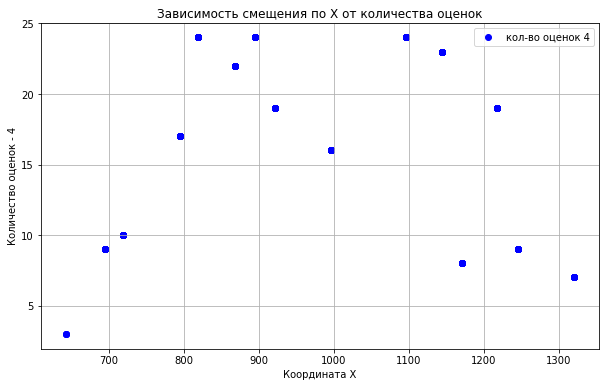

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df_hor_4['28_x'], df_hor_4['4'], color='blue', label='кол-во оценок 4')
plt.title('Зависимость смещения по X от количества оценок')
plt.xlabel('Координата X')
plt.ylabel('Количество оценок - 4')
plt.legend()
plt.grid(True)
plt.show()

Видно, что в данном случае распределение уже не является унимодальным. Из-за этого будет неправильно применять t-test. Будем использовать бутстрап для оценки 95% интервала среднего значения выборки

In [16]:
data = df_hor_4['28_x'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для смещения по горизонтали: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для смещения по горизонтали: (941.1354709925926, 1008.4751059304843)


Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "4", если центр лица на нем по горизонтали расположен в пределах  [940; 1009]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае мы получили границы смещения $\pm$5% от центра картинки.

## Вычисление остальных параметров

Аналогично рассчитаем параметры для вертикального смещения и для изменения крупности лица

In [17]:
data = df_ver_4['28_y'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для смещения по вертикали: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для смещения по вертикали: (267.3322627410119, 303.26389110514197)


Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "4", если центр лица на нем по вертикали расположен в пределах [267; 304]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае границы смещения равны - 28% и 33% от верхней границы картинки.

In [18]:
data = df_seq_4['square'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для изменений крупности лица: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для изменений крупности лица: (136623.82291948257, 158897.00412969774)


Так как в случае с получением параметров для крупности лица происходит пересечение, то будем считать область пересечения ошибкой первого рода и сместим границы на [7%; 9%]

# Выводы для оценки 4

По результатам исследования оптимальными параметрами для интуитивно приятного расположения лица в кадре на оценку 4/5 являются:  
1. По горизонтали $\pm$5% от центра изображения
2. По вертикали [28%; 33%] от верхней границы изображения
3. Площадь лица должна составлять [7%; 9%] от площади всего изображения  

# Оценка 3

При вычилении параметров для оценки "3" также будем пользоваться методом бутстрап, потому что распределение не будет унимоадальным.

In [19]:
# ГОРИЗОНТАЛЬНОЕ СМЕЩЕНИЕ
df_hor_3 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('hor_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "3" поставили пользователи
num = df_hor_3.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_hor_3.iloc[i]]*(df_hor_3['3'][i] - 1))
    df_hor_3 = pd.concat([df_hor_3, tmp], ignore_index=True)


# ВЕРТИКАЛЬНОЕ СМЕЩЕНИЕ
df_ver_3 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('ver_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "3" поставили пользователи
num = df_ver_3.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_ver_3.iloc[i]]*(df_ver_3['3'][i] - 1))
    df_ver_3 = pd.concat([df_ver_3, tmp], ignore_index=True)


# КРУПНОСТЬ ЛИЦА
df_seq_3 = df_result[df_result['name'].isin(['normal']) | df_result['name'].str.startswith('seq_')]
# Содаем таблицу, где значение смещения для изображения будут повторяться столько раз, сколько оценок "3" поставили пользователи
num = df_seq_3.shape[0]
for i in range(0, num):
    tmp = pd.DataFrame([df_seq_3.iloc[i]]*(df_seq_3['3'][i] - 1))
    df_seq_3 = pd.concat([df_seq_3, tmp], ignore_index=True) 

In [20]:
# 95% доверительный интервал для горизонтального смещения
data = df_hor_3['28_x'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для смещения по горизонтали: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для смещения по горизонтали: (933.7212790329734, 1030.3956721865388)


Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "3", если центр лица на нем по горизонтали расположен в пределах  [933; 1031]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае мы получили границы смещения $\pm$8% от центра картинки.

In [21]:
data = df_ver_3['28_y'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для смещения по вертикали: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для смещения по вертикали: (185.2727604083795, 244.38821520137657)


В данном случае также происходит пересечение интервалов. Будем считать расстояние пересечения ошибкой первого рода.  
Получается, что с вероятностью 0.95 пользователь из генеральной совокупности поставит изображению оценку "3", если центр лица на нем по вертикали расположен в пределах [186; 304]  
Изначальное изображение было с разрешением 1920x950, значит в общем случае границы смещения равны - 19% и 34% от верхней границы картинки.

In [22]:
data = df_seq_3['square'].values
num_bootstrap_samples = 10000
bootstrap_statistics = np.zeros(num_bootstrap_samples)

for i in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
    bootstrap_statistics[i] = np.mean(bootstrap_sample)

std_dev_bootstrap_statistics = np.std(bootstrap_statistics, ddof=1)
confidence_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
adjusted_confidence_interval = confidence_interval + np.array([-1, 1]) * std_dev_bootstrap_statistics
print(f'95% доверительный интервал для изменений крупности лица: \
({adjusted_confidence_interval[0]}, {adjusted_confidence_interval[1]})')

95% доверительный интервал для изменений крупности лица: (117766.22144895648, 143727.1027615698)


Получаем границы [6%; 9%]

## Выводы для оценки 3

По результатам исследования оптимальными параметрами для интуитивно приятного расположения лица в кадре на оценку 3/5 являются:  
1. По горизонтали $\pm$8% от центра изображения
2. По вертикали [19%; 34%] от верхней границы изображения
3. Площадь лица должна составлять [6%; 9%] от площади всего изображения  

# Общий вывод

Результаты, полученные по итогу всех вычислений, представленны на картинке.   
* Зеленым цветом отмечены границы смещения черной точки для получения оценки 5 с вероятностью 0.95
* Желтым цветом - границы для получения оценки 4 с вероятностью 0.95
* Красным цветом - границы для получения оценки 3 с вероятностью 0.95
* Все, что будет выходить за красные границы можно считать оценкой 2 и ниже

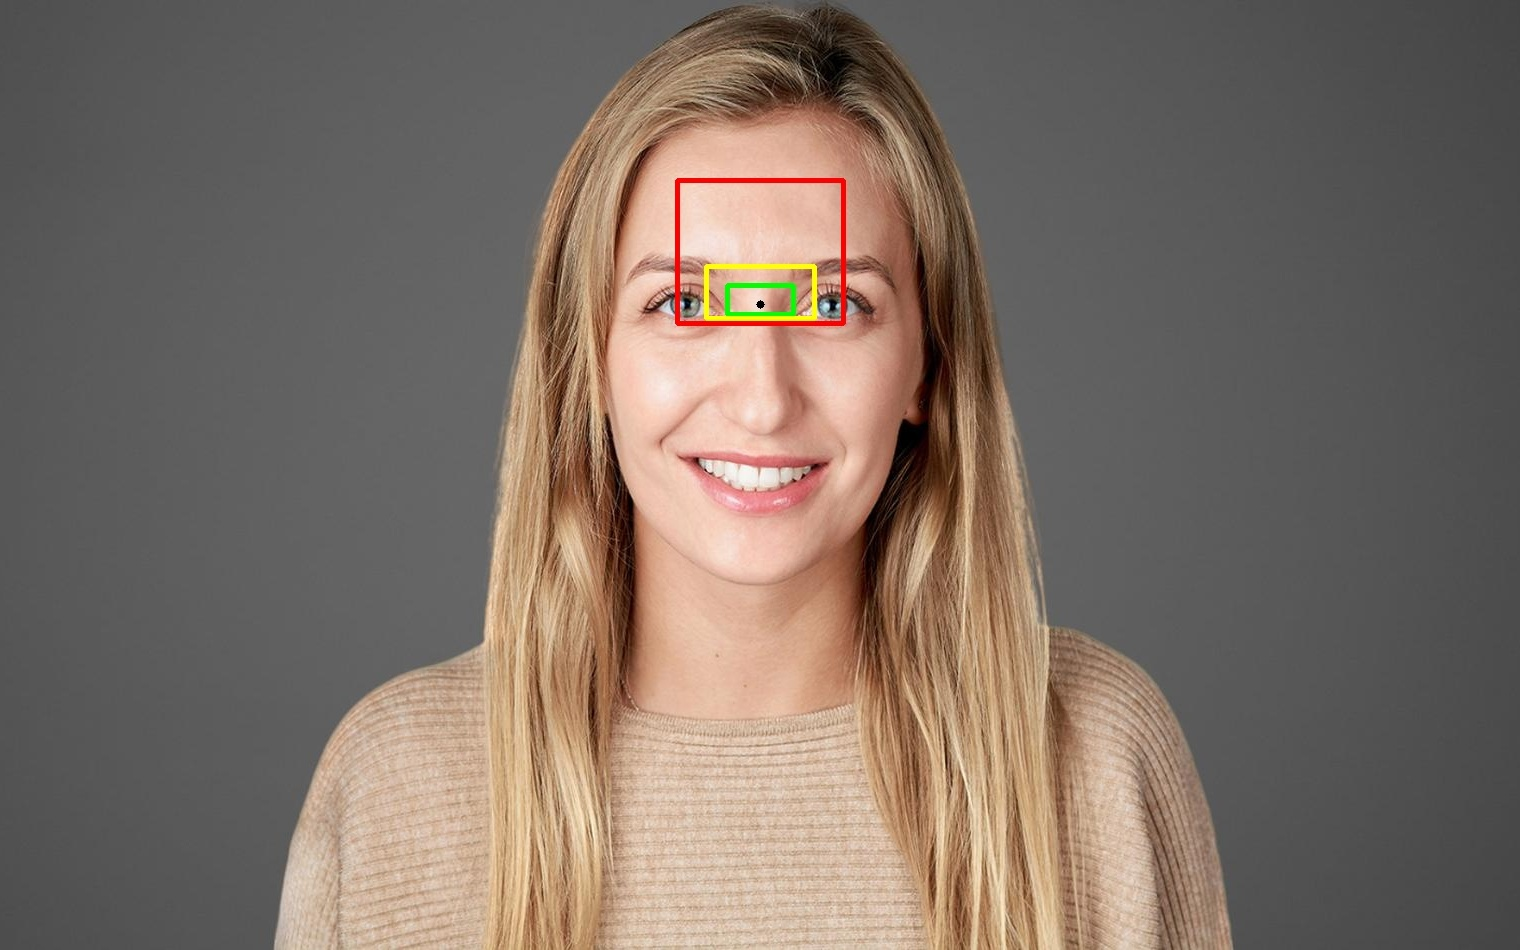